# Import Statements

In [63]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale = 1.3)

# Environment Setup

In [64]:
# NB: this will vary from machine to machine
plt.rcParams['animation.ffmpeg_path'] = '/Users/benstahl/ffmpeg'

# Simulation Class

In [65]:
class Simulation:
    
    def __init__(self, system, p, x0, ti, tf, t_steps):
        
        self.system = system # function defining a physical system
        self.p = p # tuple of parameters
        self.x0 = x0 # tuple of initial conditions
        self.ti = ti # time of intitial conditions
        self.tf = tf # time at end of simulation
        self.t_steps = t_steps # number of time steps between ti and tf
        self.t = np.linspace(ti, tf, t_steps) # time array
        self.interval = (tf - ti) / t_steps # interval between frames (for animation)
        
    def run_sim(self):
        '''
        make odeint (with arguments in place) a method for class instances
        '''
        
        return odeint(self.system, self.x0, self.t, args=(self.p,))
    
    def animate_sim(self, setup, update, fsize = (12,12), ylim = [-1.5, 0.25], xlim = [-1.5, 1.5], 
                    fname = 'animation.mp4', t_stretch = 1):
        '''
        handles creation of animation
        
        Parameters
        ----------
        (object instance)
        setup : function that sets up the plot window (annotations, labels, create plot objects to be upated)
            Parameters
            ----------
            ax : subplot instance
            Returns
            -------
            sols : tuple of plot objects
        update : function that updates plot objects
            Parameters
            ----------
            tt : time index
            x : numerical solution
            sols : tuple of plot objects
        '''
        
        # setup size, scale
        fig, ax = plt.subplots(figsize = fsize)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        
        # run setup function
        sols = setup(ax)
        
        # build and save animation
        anim = animation.FuncAnimation(fig, update, frames=len(self.t), blit = True, fargs = (self.run_sim(), sols, self.interval))
        anim.save(fname, fps=int(self.t_steps/(t_stretch * (self.tf - self.ti))), writer="ffmpeg", codec="libx264")
        plt.close(fig)

# Physical Systems

## Block on Parabolic Ramp

This system consists of a block of mass, $m$, that slides on a ramp whose surface shape is governed by the equation $y = ax^2$.

The Lagrangian for this system is given by:

$$L = T - V = \frac{1}{2}m\left(1 + 4a^2 x^2\right)\dot{x} - amgx^2$$

By applying the Euler-Lagrange equation, one obtains:

$$(1 + 4a^2x^2)\ddot{x} + 4a^2 x \dot{x}^2 + 2agx = 0$$

In the limit where the mass' motion is small, terms of order 2 and higher in $x$ and $\dot{x}$ can be neglected, yielding:

$$\ddot{x} + 2agx = 0$$

This is the equation for simple harmonic motion.

To visualize the motion of the system, we numerically solve the above equations and animate the results.

In [66]:
# define system
def block_on_parabolic_ramp(q, t, p):
    
    # unpack arguments
    x, x_dot, xsho, xsho_dot = q
    a, g = p
    
    # compute and return derivatives
    x_ddot = -2 * a * x * (2 * a * x_dot**2 + g) / (1 + 4 * a**2 * x**2)
    xsho_ddot = -2 * a * g * xsho
    return [x_dot, x_ddot, xsho_dot, xsho_ddot]

In [77]:
# run simulation

# initial conditions
x0 = [0.16, 0, 0.16, 0]

# timing
ti = 0
tf = 30
t_steps = 501

# params
a = 0.2
g = 9.8
p = (a, g)

ramp_sim = Simulation(block_on_parabolic_ramp, p, x0, ti, tf, t_steps)
x = ramp_sim.run_sim()

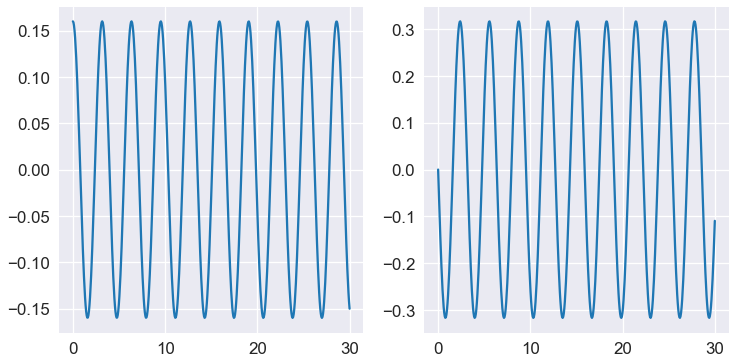

In [78]:
# quickly examine results before building animation
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(ramp_sim.t, x[:,0])
ax[1].plot(ramp_sim.t, x[:,1])

In [80]:
# create and save animation

# setup instructions for before animating
def setup(ax):
    
    # labels and title
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Block on Parabolic Ramp Simulation')
    dotx = '\dot{x}'
    params = 'Ramp: $y = {}x^2$'.format(a)
    ic = 'Initial Conditions:\n\t$x =$ {} m\n\t${} =$ {} m/s'.format(x0[0],dotx, x0[1])
    ax.text(0.75, 0.02, params + '\n' + ic, transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
    
    # add parabola to plot
    x_scale = np.linspace(-0.18, 0.18, 101)
    ax.plot(x_scale, a * x_scale**2, 'k-', label = 'Ramp')
    
    # make objects that get updated
    block, = ax.plot([], [], color="red", marker="o", markersize=15, label = 'Full Solution')
    blocksho, = ax.plot([], [], color="green", marker="o", markersize=15, label = 'Approximate (SHO) Solution')
    time = ax.text(0.02, 0.02, '', transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
    time.set_text('')
    
    # add legend
    ax.legend()
    
    # return objects that get updated
    return (block, blocksho, time)

# plot updating instructions
def update(tt, x, sols, tt_val): 
    sols[0].set_data([x[tt,0]], [a*x[tt,0]**2])
    sols[1].set_data([x[tt,2]], [a*x[tt,2]**2])
    sols[2].set_text('Time: {:.2f} s'.format(tt * tt_val))
    return sols

ramp_sim.animate_sim(setup, update, fsize = (12, 8), ylim = [-0.0007, 0.007], xlim = [-0.19, 0.19], fname='block_on_parabolic_ramp.mp4', t_stretch = 1)

## Spring Pendulum
This system consists of a mass, $m$, connected to a spring (with spring constant, $k$) in a gravitational field of constant gravitational acceleration, $g$. 

Taking $\ell + x(t)$ to be the length the spring and $\theta$ to be its angle with respect to the vertical (passing through the pivot point), the Lagrangian of the system can be expressed as:

$$L = T - V = \frac{1}{2}m\left(\dot{x}^2 + \left(\ell + x\right)^2 \dot{\theta}^2\right) + mg(\ell + x)\cos\theta - \frac{1}{2}kx^2$$

By applying the Euler-Lagrange equation, one can obtain:

$$m\ddot{x} = m\left(\ell + x\right)\dot{\theta}^2 + mg\cos\theta - kx\\
m(\ell + x)\ddot{\theta} + 2m\dot{x}\dot{\theta} = -mg\sin\theta$$

To visualize the motion of the system, we numerically solve the above equations and animate the results.


In [76]:
# define system
def spring_pendulum(y, t, p):
    
    # unpack arguments
    x, x_dot, theta, theta_dot = y
    m, k, ell, g = p
    
    # compute and return derivatives
    x_ddot = (ell + x)*theta_dot**2 + g*np.cos(theta) - (k/m)*x
    theta_ddot = -(g*np.sin(theta) + 2*x_dot*theta_dot) / (ell + x)
    return [x_dot, x_ddot, theta_dot, theta_ddot]

In [151]:
# run simulation

# initial conditions
y0 = [0.7, 0, -0.85, 0]

# timing
ti = 0
tf = 30
t_steps = 501

# params
m = 1
k = 15
ell = 2
g = 9.8
p = (m, k, ell, g)
print('m*g/k = {:.1f}'.format(m*g/k))

sp_sim = Simulation(spring_pendulum, p, y0, ti, tf, t_steps)
y = sp_sim.run_sim()

m*g/k = 0.7


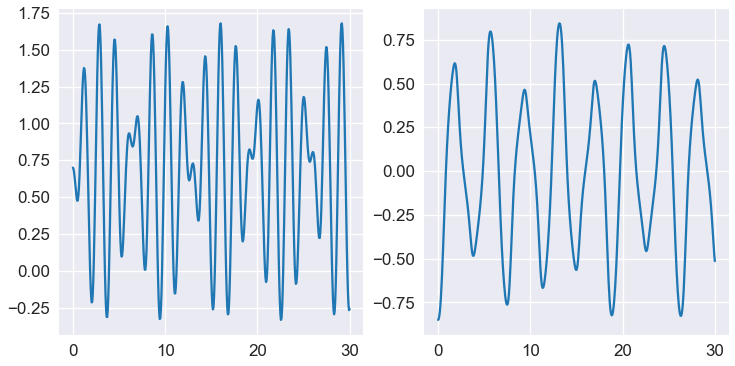

In [152]:
# quickly examine results before building animation
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(sp_sim.t, y[:,0])
ax[1].plot(sp_sim.t, y[:,2])

In [154]:
# create and save animation

# setup instructions for before animating
def setup(ax):
    
    # labels and title
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Spring Pendulum Simulation')
    dotx = '\dot{x}'
    dottheta = '\dot{\\theta}'
    params = 'Parameters:\n\t$m =$ {} kg\n\t$k =$ {} N/m\n\t$\ell =$ {} m'.format(m, k, ell)
    ic = 'Initial Conditions:\n\t$x =$ {} m\n\t${} =$ {} m/s\n\t$\\theta =$ {} rad\n\t${} =$ {} rad/s'.format(
          y0[0],dotx, y0[1], y0[2], dottheta, y0[3])
    ax.text(0.7, 0.97, params + '\n\n' + ic, transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
    # mark origin
    ax.plot([0],[0],color='black', marker="o", markersize=10)
    
    # make objects that get updated
    pendulum1, = ax.plot([], [], color="black", lw=1)
    circle, = ax.plot([], [], color="red", marker="o", markersize=20)
    time = ax.text(0.03, 0.97, '', transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    time.set_text('')
    
    # return objects that get updated
    return (pendulum1, circle, time)

# plot updating instructions
def update(tt, y, sols, tt_val): 
    sols[2].set_text('Time: {:.2f} s'.format(tt * tt_val))
    x1 = + (ell + y[tt,0]) * np.sin(y[tt, 2])
    y1 = - (ell + y[tt,0]) * np.cos(y[tt, 2])
    sols[0].set_data([0,x1], [0,y1])
    sols[1].set_data([x1], [y1])
    return sols

sp_sim.animate_sim(setup, update, ylim = [-4, 0.5], xlim = [-4.5, 4.5], fname='spring_pendulum.mp4', t_stretch = 1)